# Without sWeights: `common_B0TODst3pi_Dst_constr_BDT-1.25`

# Plot the fit
    
I just want to recreate the figure of the fit to $m(3\pi)$ around $m(D^*)_{PDG}$ with BDT > -1.25, with the colors I cherish.


In [12]:
name_data = 'common_B0TODst3pi_Dst_constr'
name_data_B0toDstDs = 'common_B0TODstDs_Dst_constr'

name_data_Dstto3pi = 'common_DstTO3pi' # same as sWeights as the unconstrained case

name_BDT = 'gradient'

name_data_MC = 'MC_constr_opposedCB_sharedMean'
name_data_KPiPi = "data_KPiPi_constr"

BDT = -1.25

name_data_BDT = name_data + f'_BDT{BDT}'
name_data_B0toDstDs_BDT = name_data_B0toDstDs + f'_BDT{BDT}'

## Import

In [13]:
import zfit
import json
import numpy as np
import timeit

from numpy.random import normal

from math import sqrt

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_saved_root, load_data, add_constr_Dst, json_to_latex_table, retrieve_params, format_previous_params
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from fit import define_zparams, sum_crystalball
from variables import name_params, name_params_KPiPi

In [3]:
name_params_KPiPi_print = {}
for key, value in name_params_KPiPi.items():
    name_params_KPiPi_print[key+'_Kpipi'] = name_params_KPiPi[key]

## Load

### Json files

In [4]:
name_data_BDT = f"{name_data}_BDT{BDT}"
name_data_B0toDstDs_BDT = f"{name_data_B0toDstDs}_BDT{BDT}"

# Fixed alphaL, alphaR and nL
common_params = retrieve_params(name_data, name_folder=name_data)
# Fixed nR
MC_params = retrieve_params(name_data_MC, name_folder='MC')

# B0->DstKPiPi
Kpipi_params = retrieve_params(name_data_KPiPi, name_folder='data_KPiPi') # already in MeV 

# common with BDT cut (for startning values of the fit)
pipipi_params = format_previous_params(retrieve_params(name_data_BDT, name_folder=name_data), True)
# B0->DstDs with BDT cut (for the B0->DstDs PDF shape)
DstDs_params = format_previous_params(retrieve_params(name_data_B0toDstDs_BDT, name_folder=name_data_B0toDstDs), True) 

Load 
- `f_params_dict['1']` - the fixed parameters that will be changed in **mode 1**
- `f_params_dict['2']`  - the fixed parameters that will be changed in **mode 2**

In [5]:
f_params = {} # fixed parameters

for param in 'alphaL', 'alphaR', 'nL', 'r_bkgK':
    f_params[param] = common_params[param] # nominal value

f_params['nR'] = {}
f_params['nR']= MC_params['nR_MC']

for param in 'muL', 'muR', 'nL', 'nR', 'alphaR', 'alphaL', 'sigmaL', 'sigmaR', 'fraction':
    f_params[param+'_Kpipi'] = Kpipi_params[param]


In [6]:
df = load_saved_root('common_'+name_BDT, name_folder='common', vars=['B0_M', 'Dst_M', 'BDT'])
df = df.query(f"BDT > {BDT}")
df = add_constr_Dst(df)

/afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_gradient.root


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data_cut_-1.25


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Candidates / (0.07)'>)

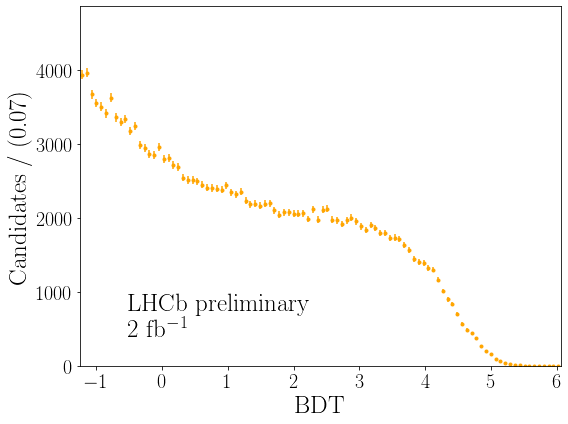

In [7]:
h.plot_hist_particle({'data\_cut\_-1.25': df},'BDT',
              n_bins = 100, mode_hist = False, colors=['orange', 'cyan'], pos_text_LHC=[0.1,0.2,'left'])

## Range of the variables

### Constrained $m(D^* 3\pi)$ of the `common` data

In [7]:
var = 'Dst_constr_B0_M'
low = 5150.
high = 5545.

## PLOT

### Values

In [8]:
initial_values = {
    # Signal        
    'mu'       :{ 'value': pipipi_params['mu']       , 'floating': True},
    'sigmaL'   :{ 'value': pipipi_params['sigmaL']   , 'floating': True},
    'sigmaR'   :{ 'value': pipipi_params['sigmaR']   , 'floating': True},
    'frac'     :{ 'value': pipipi_params['frac']     , 'floating': True},
    'n_sig'    :{ 'value': pipipi_params['n_sig']    , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': pipipi_params['lambda']   , 'floating': True},
    'n_bkg'    :{ 'value': pipipi_params['n_bkg']    , 'floating': True},
    # Background decay D*Kpipi    
}

# Fixed parameters:
for param, value_param in f_params.items():
    initial_values[param] = {}
    initial_values[param]['value'] = value_param
    initial_values[param]['floating'] = False

# B0 -> D* Ds distribution
for vari in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{vari}_Ds'] = {'value': DstDs_params[f'{vari}_DstDs'], 'floating': False}

### Observables and variables

In [9]:
obs = zfit.Space("x", limits=(low, high))

zparams = define_zparams(initial_values)

mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter(f"n_bkgK", mult, params=[zparams['r_bkgK'],zparams['n_sig']])    

### PDFs

In [10]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_Kpipi'], zparams['muR_Kpipi'], 
                                                          zparams['sigmaL_Kpipi'], zparams['sigmaR_Kpipi'],
                                                          zparams['fraction_Kpipi'], obs,
                                                          zparams['alphaL_Kpipi'], zparams['alphaR_Kpipi'], 
                                                          zparams['nL_Kpipi'], zparams['nR_Kpipi'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_Ds_ext = gaussian_Ds.create_extended(zparams['n_sig_Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac

### Plotting

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/fit.py:539: UserWarning: The function <function Space.limits at 0x7f6c7ad3a710> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5545.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/fit.py:45: UserWarning: The function <function Space.area at 0x7f6c7ad3fb00> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5545.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  return counts.sum() * obs.area() / n_bins


Number of d.o.f. in the model:  7
Reduced chi2:  1.7177543588766973


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_BDT-1.25_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

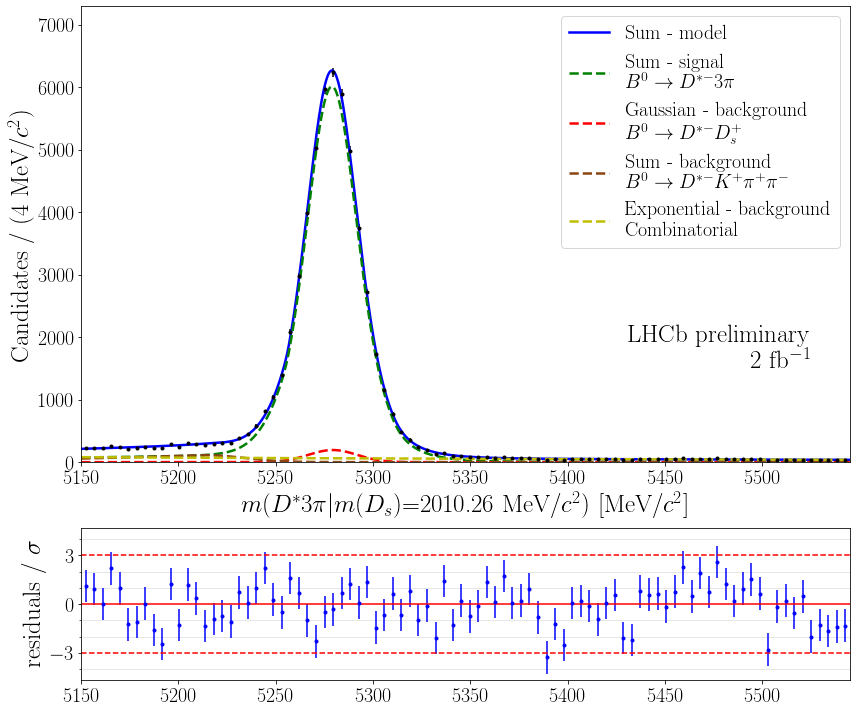

In [11]:
name_data_plot = name_data + f'_BDT{BDT}'
plot_hist_fit_particle(df,var, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 90,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )

### Params

In [14]:
fitted_params = retrieve_params(name_data_BDT, name_folder=name_data)

In [15]:
fitted_params

{'frac|BDT-1.25': 0.42610994233365423,
 'frac|BDT-1.25_err': 0.020566239640029654,
 'info_fit': '------------------------------------------------------------------\n| FCN = -3.199e+05              |     Ncalls=103 (103 total)     |\n| EDM = 4.67e-06 (Goal: 0.001)  |            up = 0.5            |\n------------------------------------------------------------------\n|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |\n------------------------------------------------------------------\n|     True      |     True      |   False   |       False        |\n------------------------------------------------------------------\n| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |\n------------------------------------------------------------------\n|     False     |     True      |   True    |   True    | False  |\n------------------------------------------------------------------',
 'lambda|BDT-1.25': -0.0019334669508350583,
 'lambda|BDT-1.25_err': 0.0002705012560095

In [16]:
json_to_latex_table(name_data_BDT, name_data, name_params)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_B0TODst3pi_Dst_constr/common_B0TODst3pi_Dst_constr_BDT-1.25_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$f_{\frac{L}{R}}$&$0.426\pm0.021$\\
\hline
$\lambda_{B,c}$&$-0.00193\pm0.00027$\\
\hline
$\mu_S$&$5278.866\pm0.077$\\
\hline
B&$1299\pm47$\\
\hline
$n_{B,c}$&$(5.00\pm0.18)\times 10^3$\\
\hline
$n_S$&$(5.232\pm0.028)\times 10^4$\\
\hline
$\sigma_{L, S}$&$10.95\pm0.22$\\
\hline
$\sigma_{R, S}$&$18.11\pm0.22$\\
\hline
\end{tabular}


### Compare $B^0 \to D^* D_s$ and $B^0 \to D^* (D_s \to 3\pi)$
$$\mathcal{B}\left(B^0 \to D^{*-} D_s \right) = (8.0 \pm 1.1)\times 10^{-3}$$
$$\mathcal{B}\left(D_{s}^+ \to \pi^+ \pi^+ \pi^- \right) = (1.08 \pm 0.04)\times 10^{-2}$$

In [17]:
from uncertainties import ufloat

### $\frac{\mathcal{B}(B^0\to D^*D_s)}{\mathcal{B}(B^0\to D^*3\pi)}$, from the PDG

In [18]:
normal_mode_br = ufloat(7.21e-3, 0.29e-3)

In [20]:
bkgDs_br = ufloat(8.0e-3, 1.1e-3)*ufloat(1.08e-2, 0.04e-2)
print(bkgDs_br/normal_mode_br)
r_br_Ds = bkgDs_br/normal_mode_br

0.0120+/-0.0018


### $\frac{n_{B^0\to D^*D_s}}{n_{B^0\to D^*3\pi}}$, from the fit

In [21]:
fitted_params_Ds = retrieve_params(name_data_B0toDstDs_BDT, name_folder=name_data_B0toDstDs)
n_bkgDs = ufloat(fitted_params_Ds['n_sig_DstDs|BDT-1.25'], fitted_params_Ds['n_sig_DstDs|BDT-1.25_err'])

In [22]:
n_normal_mode = ufloat(fitted_params['n_sig|BDT-1.25'],fitted_params['n_sig|BDT-1.25_err'])

In [23]:
r_bkgDs = n_bkgDs/n_normal_mode
print(r_bkgDs)

0.0264+/-0.0010


In [24]:
print(r_bkgDs/r_br_Ds)

2.20+/-0.34
